In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Network

## Session 8a - Introduction to Tensorflow
## FIFA dataset 

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np # type: ignore
import pandas as pd # type: ignore

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
import matplotlib.pyplot as plt # type: ignore

import tensorflow as tf # type: ignore


# os.chdir("/home/pgdai/Desktop/DNN-May24/study material-20240518T025337Z-001/study material/utils")
# from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

2024-05-20 16:22:06.357265: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 16:22:06.408657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 16:22:06.408695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 16:22:06.409828: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-20 16:22:06.417215: I tensorflow/core/platform/cpu_feature_guar

In [3]:

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [4]:

###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()


In [5]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


In [6]:
print (fn_plot_torch_hist.__doc__)

None


In [7]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [8]:
###----------------------
### Some basic parameters
###----------------------

#Directories so that we can save the trained model, the outputs and the inputs
inpDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureThings/Day5/input'
outDir = '../../../output'
modelDir = '../../../models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101 # number of epochs
BATCH_SIZE = 32 #default of tensorflow
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [9]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [10]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [11]:
for col in data_df.columns:
    print(f"{col}: {data_df[col].unique}")

Unnamed: 0: <bound method Series.unique of 0            0
1            1
2            2
3            3
4            4
         ...  
18202    18202
18203    18203
18204    18204
18205    18205
18206    18206
Name: Unnamed: 0, Length: 18207, dtype: int64>
ID: <bound method Series.unique of 0        158023
1         20801
2        190871
3        193080
4        192985
          ...  
18202    238813
18203    243165
18204    241638
18205    246268
18206    246269
Name: ID, Length: 18207, dtype: int64>
Name: <bound method Series.unique of 0                  L. Messi
1         Cristiano Ronaldo
2                 Neymar Jr
3                    De Gea
4              K. De Bruyne
                ...        
18202          J. Lundstram
18203    N. Christoffersson
18204             B. Worman
18205        D. Walker-Rice
18206             G. Nugent
Name: Name, Length: 18207, dtype: object>
Age: <bound method Series.unique of 0        31
1        33
2        26
3        27
4        27
         ..


In [12]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [13]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18147.0,9089.239599,5257.923360,0.0,4536.5,9076.0,13662.5,18206.0
ID,18147.0,214279.818868,29970.319078,16.0,200305.5,221740.0,236512.5,246620.0
Age,18147.0,25.121122,4.669796,16.0,21.0,25.0,28.0,45.0
Overall,18147.0,66.253926,6.913320,46.0,62.0,66.0,71.0,94.0
Potential,18147.0,71.324076,6.132286,48.0,67.0,71.0,75.0,95.0
Special,18147.0,1598.002645,272.882706,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18147.0,1.113297,0.394150,1.0,1.0,1.0,1.0,5.0
Weak Foot,18147.0,2.947154,0.660498,1.0,3.0,3.0,3.0,5.0
Skill Moves,18147.0,2.361492,0.756274,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [14]:
data_df['Position'].isnull().sum()

0

In [15]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [50]:
class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [16]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [17]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [18]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [19]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [20]:
features_df = data_df.drop("Position", axis = 1)
labels = data_df['Position']

In [21]:
# splitting in train ans test datasets
X_train, X_test, y_train, y_test = train_test_split(features_df, labels,
                                     stratify=labels,
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [22]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [23]:
list(labels.keys())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


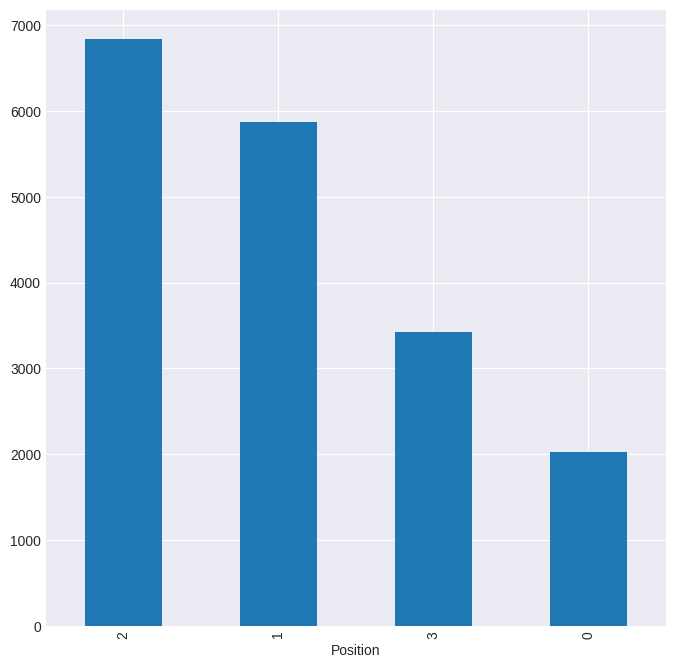

In [24]:
fig = plt.figure(figsize=(8,8))
data_df['Position'].value_counts().plot(kind = "bar");


In [25]:
X_train.shape

(14517, 33)

# Prepare Model

In [26]:
# Calling class Sequential and pass all layers as a list
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(18, activation=tf.nn.silu), # alternatively activation = 'swish' 
  tf.keras.layers.Dense(4) # notice absence of softmax function
])

2024-05-20 16:22:10.955495: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# Functional API

In [27]:
inputs = tf.keras.Input(shape=(33,))
    
x = tf.keras.layers.Dense(18, activation=tf.nn.relu)(inputs)

# tf.keras.layers.Dense(
#     units,
#     activation=None,
#     use_bias=True,
#     kernel_initializer='glorot_uniform',
#     bias_initializer='zeros',
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     lora_rank=None,
#     **kwargs
# ) keep defaults are defaults


outputs = tf.keras.layers.Dense(4)(x)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [28]:
X_train[:1].shape

(1, 33)

In [29]:
X_train[:1]

array([[ 0.84396466,  0.27358763, -0.52239617,  0.23109725,  0.29705091,
        -0.28022877, -0.90549975, -0.76923736,  0.03641655,  0.69690341,
         0.56150403,  0.64223997, -0.31191556,  0.42687437,  0.09102389,
        -0.00583853, -0.0156703 , -0.26906524,  0.14948988, -0.39569289,
        -1.58556533,  0.56596068, -0.45127189,  0.92378593, -0.5824395 ,
        -1.31972485, -1.46321229, -1.58353669, -0.31775841, -0.55501322,
        -0.37748688, -0.25744747, -0.31840455]])

In [30]:
predictions = model(X_train[:1]).numpy()
predictions

array([[-0.38738224,  0.4180111 , -0.19803847, -0.20555624]],
      dtype=float32)

In [31]:
predictions.sum()

-0.37296587

In [32]:
tf.nn.softmax(predictions).numpy()

array([[0.17713416, 0.39635125, 0.21405888, 0.21245569]], dtype=float32)

In [33]:
tf.nn.softmax(predictions).numpy().sum()

0.99999994

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 18)                   612       
                                                                 
 dense_1 (Dense)             (1, 4)                    76        
                                                                 
Total params: 688 (2.69 KB)
Trainable params: 688 (2.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy ( from_logits = True)

In [36]:
loss_fn(y_train[:1], predictions).numpy()

1.5490217

In [37]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [38]:
history = model.fit(X_train, y_train, 
                    validation_data=[X_test, y_test],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/101
454/454 [==============================] - 2s 4ms/step - loss: 0.5142 - accuracy: 0.7974 - val_loss: 0.3686 - val_accuracy: 0.8477
Epoch 2/101
454/454 [==============================] - 2s 4ms/step - loss: 0.3346 - accuracy: 0.8646 - val_loss: 0.3263 - val_accuracy: 0.8576
Epoch 3/101
454/454 [==============================] - 2s 3ms/step - loss: 0.3111 - accuracy: 0.8724 - val_loss: 0.3141 - val_accuracy: 0.8661
Epoch 4/101
454/454 [==============================] - 2s 4ms/step - loss: 0.3024 - accuracy: 0.8754 - val_loss: 0.3076 - val_accuracy: 0.8664
Epoch 5/101
454/454 [==============================] - 2s 4ms/step - loss: 0.2976 - accuracy: 0.8778 - val_loss: 0.3053 - val_accuracy: 0.8647
Epoch 6/101
454/454 [==============================] - 2s 3ms/step - loss: 0.2942 - accuracy: 0.8789 - val_loss: 0.3028 - val_accuracy: 0.8675
Epoch 7/101
454/454 [==============================] - 2s 4ms/step - loss: 0.2922 - accuracy: 0.8798 - val_loss: 0.2994 - val_accuracy: 0.8702

In [39]:
model.evaluate ( X_test,  y_test, verbose=2)

114/114 - 0s - loss: 0.3045 - accuracy: 0.8725 - 242ms/epoch - 2ms/step


[0.30446070432662964, 0.8724517822265625]

In [40]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.514164,0.797410,0.368631,0.847658
1,0.334623,0.864641,0.326318,0.857576
2,0.311067,0.872425,0.314063,0.866116
3,0.302367,0.875387,0.307625,0.866391
4,0.297571,0.877798,0.305329,0.864738


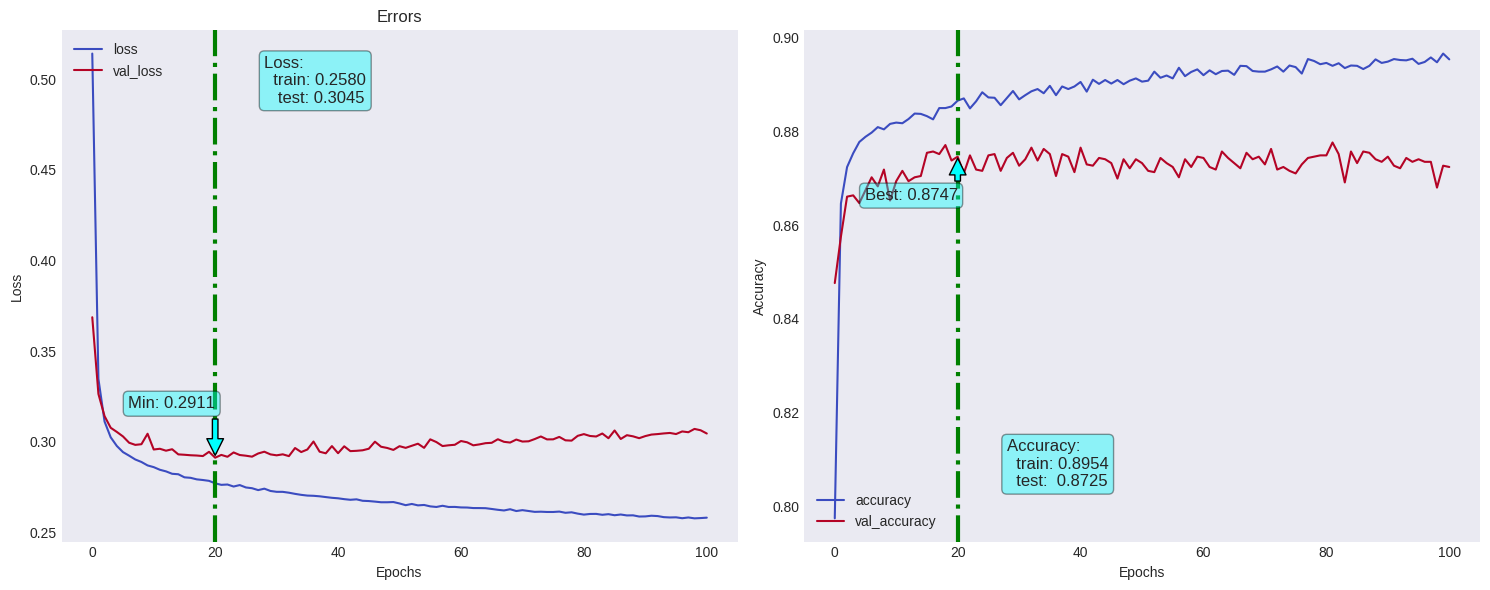

In [41]:
fn_plot_tf_hist(loss_df)

# the red line should follow the blue line as closely as poosible till the end. At the end, it should diverge a bit

In [42]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
20,0.276967,0.886616,0.291116,0.874656


# Predictions

In [43]:
probability_model = tf.keras.Sequential([
    model, 
    tf.keras.layers.Softmax()
])

In [44]:
y_pred = probability_model(X_train).numpy()
y_pred

array([[1.2999305e-15, 2.2238966e-09, 2.7848398e-02, 9.7215164e-01],
       [6.9236248e-17, 2.4787823e-09, 6.2778765e-01, 3.7221229e-01],
       [4.0273465e-19, 5.3214929e-08, 7.2753924e-01, 2.7246076e-01],
       ...,
       [1.0000000e+00, 1.9541753e-10, 2.1270815e-12, 7.1088337e-11],
       [1.0000000e+00, 4.1292044e-12, 3.3721468e-15, 3.5522158e-13],
       [1.0000000e+00, 1.1273511e-12, 1.5761110e-14, 2.0063961e-12]],
      dtype=float32)

In [45]:
print(classification_report( y_train, y_pred.argmax( axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.93      0.93      0.93      4693
           2       0.85      0.88      0.87      5470
           3       0.87      0.80      0.83      2734

    accuracy                           0.90     14517
   macro avg       0.91      0.90      0.91     14517
weighted avg       0.90      0.90      0.90     14517



In [46]:
y_pred = probability_model(X_test).numpy()

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(y_test, 
                                                                  np.argmax(y_pred, axis = 1))))

Accuracy score on Test Data :0.87245


In [47]:
print(classification_report(y_test, 
                            np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.92      0.92      1173
           2       0.82      0.86      0.84      1368
           3       0.83      0.75      0.78       684

    accuracy                           0.87      3630
   macro avg       0.89      0.88      0.89      3630
weighted avg       0.87      0.87      0.87      3630



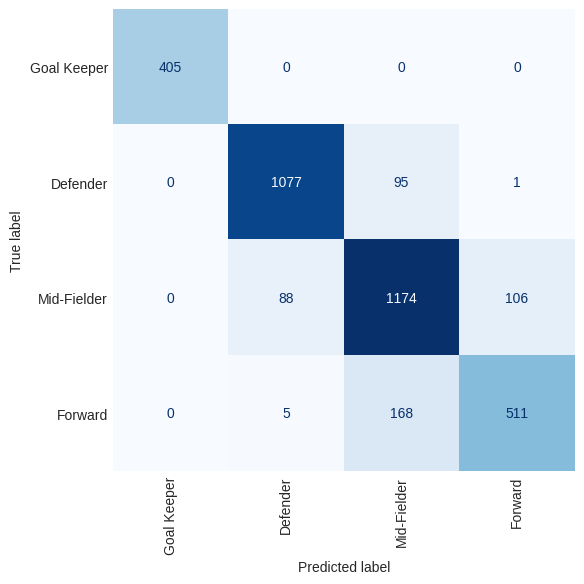

In [52]:
fn_plot_confusion_matrix( y_test, y_pred.argmax( axis = 1), labels=class_labels)